# Experiment with V1

1. Create the BSAF here, takes 20 mins max
2. reset weights
3. Update weights according to facts
4. Run QE and DF-QUAD with min-set-aggregation
5. Run QE and Linear influence again but with the top aggregation
6. Try other aggregations as well. Will investigate properties later.
7. Do experiments all + greedy. Plot CID scores against each other!

New Plan: QE did not converge, also strengths don't make sense with Product aggregation of DF-QUAD  
SO doing DF-QUAD linear influence but with top-diff aggregation. Now strengths make sense

In [1]:
import sys
sys.path.append("../..")  # Adjust the path to import from the parent directory
sys.path.append("../../aspforaba")
sys.path.append("../../GradualABA")
sys.path.insert(0, '../../ArgCausalDisco/')
sys.path.insert(0, '../../notears/')

from aspforaba.src.aspforaba.abaf import ABAF
import src.causal_aba.assumptions as asms
import src.causal_aba.atoms as atoms
import networkx as nx
from src.utils.utils import unique_product, powerset

from GradualABA.ABAF import ABAF as GradualABAF
from GradualABA.semantics.bsafDiscreteModular import DiscreteModular
from GradualABA.semantics.modular.LinearInfluence import LinearInfluence
from GradualABA.semantics.modular.ProductAggregation import ProductAggregation
from GradualABA.semantics.modular.SetProductAggregation import SetProductAggregation
from GradualABA.semantics.modular import SumAggregation
from GradualABA.semantics.modular.SetMinAggregation import SetMinAggregation
from GradualABA.semantics.modular import QuadraticMaximumInfluence


import time
from pathlib import Path
from src.utils.enums import Fact, RelationEnum
from src.utils.bn_utils import get_dataset
from ArgCausalDisco.utils.helpers import random_stability
from itertools import combinations

from ArgCausalDisco.cd_algorithms.PC import pc
from ArgCausalDisco.utils.graph_utils import initial_strength


/homes/yh2024/gradual-sem-causal-aba/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:root:You can use `os.environ['CASTLE_BACKEND'] = backend` to set the backend(`pytorch` or `mindspore`).
INFO:root:You are using ``pytorch`` as the backend.


In [2]:
from src.abapc import get_cg_and_facts
from ArgCausalDisco.causalaba import CausalABA

In [3]:
ALPHA = 0.01
INDEP_TEST = 'fisherz'

SAMPLE_SIZE = 5000
RESULT_DIR = Path("./results/")

dataset_name = 'cancer'
seed = 2025

X_s, B_true = get_dataset(dataset_name,
                        seed=seed,
                        sample_size=SAMPLE_SIZE)

# get facts from pc
uc_rule = 5
data = X_s

random_stability(seed)

INFO:root:==================Loading cancer dataset==================
Generating for node: Dyspnoea: 100%|██████████| 5/5 [00:00<00:00, 571.91it/s]
INFO:root:Data shape: (5000, 5)
INFO:root:Number of true edges: 4
INFO:root:True BN edges: [('Pollution', 'Cancer'), ('Smoker', 'Cancer'), ('Cancer', 'Xray'), ('Cancer', 'Dyspnoea')]
INFO:root:DAG? True
INFO:root:True DAG shape: (5, 5), True DAG edges: 4
INFO:root:           Cancer  Dyspnoea  Pollution  Smoker  Xray
Cancer          0         1          0       0     1
Dyspnoea        0         0          0       0     0
Pollution       1         0          0       0     0
Smoker          1         0          0       0     0
Xray            0         0          0       0     0


In [ ]:
cg, facts = get_cg_and_facts(data, alpha=ALPHA, indep_test=INDEP_TEST, uc_rule=uc_rule)

In [5]:
def generate_fact_tuple(fact):
    X, Y, S, dep_type_PC, I = fact.node1, fact.node2, fact.node_set, fact.relation.value, fact.score
    s_str = 'empty' if len(S)==0 else 's'+'y'.join([str(i) for i in S])
    return(X,S,Y,dep_type_PC, f"{dep_type_PC}({X},{Y},{s_str}).", I)


def get_fact_location(facts, base_location='./facts.lp'):

    facts_location = base_location
    facts_location_wc = base_location.replace('.lp', '_wc.lp')
    facts_location_I = base_location.replace('.lp', '_I.lp')

    facts = [generate_fact_tuple(fact) for fact in facts]


    ### Save external statements
    with open(facts_location, "w") as f:
        for n, s in enumerate(facts):
            f.write(f"#external ext_{s[4]}\n")
    ### Save weak constraints
    with open(facts_location_wc, "w") as f:
        for n, s in enumerate(facts):
            f.write(f":~ {s[4]} [-{int(s[5]*1000)}]\n")
    ### Save inner strengths
    with open(facts_location_I, "w") as f:
        for n, s in enumerate(facts):
            f.write(f"{s[4]} I={s[5]}, NA\n")
        
    return facts_location

In [6]:
facts_location = get_fact_location(facts, base_location='./cancer_facts.lp')

In [7]:
facts_location

'./cancer_facts.lp'

In [8]:
n_nodes = data.shape[1]
print(f"Number of nodes: {n_nodes}")

Number of nodes: 5


### Original Fact Strengths, Original Causal ABA

In [ ]:
model_sets, multiple_solutions = CausalABA(
    n_nodes, facts_location, weak_constraints=True, skeleton_rules_reduction=True,
    fact_pct=1.0, search_for_models='first',
    opt_mode='optN', print_models=False, set_indep_facts=False);

### Refined Fact Strengths, Original Causal ABA

In [10]:

import src.gradual.extra.abaf_factory_v1
import importlib
importlib.reload(src.gradual.extra.abaf_factory_v1)

from src.gradual.extra.abaf_factory_v1 import FactoryV1


from src.gradual.run import run_get_bsaf_and_assum_dict, reset_weights, set_weights_according_to_facts
from src.gradual.abaf_opt import ABAFOptimised
from GradualABA.semantics.modular.SetMinAggregation import SetMinAggregation
from src.gradual.model_wrapper import ModelEnum
from src.gradual.run import run_model

In [11]:
factory = FactoryV1(n_nodes=n_nodes)

bsaf, assumptions_dict = run_get_bsaf_and_assum_dict(
    factory=factory,
    facts=[],
    set_aggregation=SetMinAggregation(),
    abaf_class=ABAFOptimised,)

iterating through node combinations:   0%|          | 0/10 [00:00<?, ?it/s]

Building arguments: 100%|██████████| 1390/1390 [00:09<00:00, 144.11it/s]

[2025-07-18 20:21:12] INFO - app - Pruning supersets from derivations



INFO:app:Pruning supersets from derivations


In [12]:
reset_weights(assumptions_dict)
set_weights_according_to_facts(assumptions_dict, facts)

In [13]:
# Check that weights has changed
assum = next(a for a in bsaf.assumptions if a.initial_weight > 0.55)
assum

Assumption(indep_1_3__0, contrary=-indep_1_3__0, weight=0.7127462671626099)

In [14]:
# run model, get new fact strengths
# does not converge with QE
output = run_model(
    n_nodes=n_nodes,
    bsaf=bsaf,
    model_name=ModelEnum.QE,
    set_aggregation=SetMinAggregation(),
    conservativeness=1,
    iterations=50,
)
all(output.has_converged_map.values())

[2025-07-18 20:21:15] INFO - app - solving BSAF with GradualCausalABA


INFO:app:solving BSAF with GradualCausalABA



Discrete modular, iterations:  50 
-------
Aggregation:  SumAggregation
Influence:  QuadraticMaximumInfluence
Set Aggregation:  SetMinAggregation
-------

iter	active_path_0_1__0__	 active_path_0_1__0__2	 active_path_0_1__0__2_3	 active_path_0_1__0__2_3_4	 active_path_0_1__0__2_4	 active_path_0_1__0__3	 active_path_0_1__0__3_4	 active_path_0_1__0__4	 active_path_0_1__10__	 active_path_0_1__10__2	 active_path_0_1__10__2_3	 active_path_0_1__10__2_3_4	 active_path_0_1__10__2_4	 active_path_0_1__10__3	 active_path_0_1__10__3_4	 active_path_0_1__10__4	 active_path_0_1__11__	 active_path_0_1__11__2	 active_path_0_1__11__2_3	 active_path_0_1__11__2_3_4	 active_path_0_1__11__2_4	 active_path_0_1__11__3	 active_path_0_1__11__3_4	 active_path_0_1__11__4	 active_path_0_1__12__	 active_path_0_1__12__2	 active_path_0_1__12__2_3	 active_path_0_1__12__2_3_4	 active_path_0_1__12__2_4	 active_path_0_1__12__3	 active_path_0_1__12__3_4	 active_path_0_1__12__4	 active_path_0_1__13__	 active_path_0_1__13_

False

In [ ]:
# run model, get new fact strengths
output = run_model(
    n_nodes=n_nodes,
    bsaf=bsaf,
    model_name=ModelEnum.DF_QUAD,
    set_aggregation=SetMinAggregation(),
    conservativeness=1,
    iterations=50,
)

In [16]:
output.__dict__.keys()

dict_keys(['arrow_strengths', 'indep_strengths', 'greedy_graph', 'graph_data', 'has_converged_map'])

In [17]:
all(output.has_converged_map.values())
# Yeey, converges with DF_QUAD

True

In [18]:
output.indep_strengths

{'indep_1_3__0': np.float64(3.6637359812630166e-15),
 'indep_1_3__': np.float64(0.0),
 'indep_0_1__3': np.float64(2.0261570199409107e-15),
 'indep_0_3__2_4': np.float64(3.9988391281609026e-07),
 'indep_1_4__0_3': np.float64(8.0104187560881e-07),
 'indep_0_1__2_4': np.float64(4.0011524365946016e-07),
 'indep_0_1__2_3_4': np.float64(0.00026440474375932776),
 'indep_2_4__0': np.float64(4.440892098500626e-16),
 'indep_2_4__1': np.float64(5.551115123125783e-17),
 'indep_1_2__0_4': np.float64(8.010418708903622e-07),
 'indep_2_4__1_3': np.float64(7.987596611913617e-07),
 'indep_0_3__1_2': np.float64(3.9988317623862457e-07),
 'indep_1_4__3': np.float64(2.7755575615628914e-16),
 'indep_3_4__': np.float64(0.0),
 'indep_0_1__3_4': np.float64(4.0013695024043727e-07),
 'indep_0_3__2': np.float64(2.0261570199409107e-15),
 'indep_0_4__1_2': np.float64(3.9988317623862457e-07),
 'indep_1_3__0_2': np.float64(8.010418575676859e-07),
 'indep_2_4__3': np.float64(5.551115123125783e-17),
 'indep_1_4__2': np.

In [19]:
# extrimely small indep strengths.
# Now will try the Top aggregation instead of product aggregation for linear influence

In [20]:
from src.gradual.semantic_modules.TopDiffAggregation import TopDiffAggregation

In [21]:
# run model, get new fact strengths

from GradualABA.semantics.modular import LinearInfluence
output = run_model(
    n_nodes=n_nodes,
    bsaf=bsaf,
    model_name=None,
    set_aggregation=SetMinAggregation(),
    aggregation=TopDiffAggregation(),
    influence=LinearInfluence(conservativeness=1),
    conservativeness=1,
    iterations=50,
)

[2025-07-18 20:21:29] INFO - app - solving BSAF with GradualCausalABA


INFO:app:solving BSAF with GradualCausalABA



Discrete modular, iterations:  50 
-------
Aggregation:  TopAggregation
Influence:  LinearInfluence
Set Aggregation:  SetMinAggregation
-------

iter	active_path_0_1__0__	 active_path_0_1__0__2	 active_path_0_1__0__2_3	 active_path_0_1__0__2_3_4	 active_path_0_1__0__2_4	 active_path_0_1__0__3	 active_path_0_1__0__3_4	 active_path_0_1__0__4	 active_path_0_1__10__	 active_path_0_1__10__2	 active_path_0_1__10__2_3	 active_path_0_1__10__2_3_4	 active_path_0_1__10__2_4	 active_path_0_1__10__3	 active_path_0_1__10__3_4	 active_path_0_1__10__4	 active_path_0_1__11__	 active_path_0_1__11__2	 active_path_0_1__11__2_3	 active_path_0_1__11__2_3_4	 active_path_0_1__11__2_4	 active_path_0_1__11__3	 active_path_0_1__11__3_4	 active_path_0_1__11__4	 active_path_0_1__12__	 active_path_0_1__12__2	 active_path_0_1__12__2_3	 active_path_0_1__12__2_3_4	 active_path_0_1__12__2_4	 active_path_0_1__12__3	 active_path_0_1__12__3_4	 active_path_0_1__12__4	 active_path_0_1__13__	 active_path_0_1__13__2	 active

In [22]:
all(output.has_converged_map.values())

True

In [ ]:
output.indep_strengths

In [24]:
# yeey, reasonable strengths

(array([ 4., 12.,  1., 12.,  0.,  4.,  0.,  0., 18., 17.,  1.,  0.,  1.,
         4.,  1.,  4.,  0.,  0.,  0.,  1.]),
 array([0.   , 0.024, 0.048, 0.072, 0.096, 0.12 , 0.144, 0.168, 0.192,
        0.216, 0.24 , 0.264, 0.288, 0.312, 0.336, 0.36 , 0.384, 0.408,
        0.431, 0.455, 0.479]),
 <BarContainer object of 20 artists>)

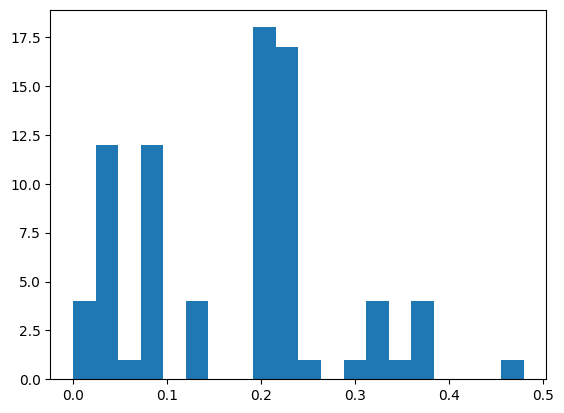

In [25]:
strengths = list(output.indep_strengths.values())

import matplotlib.pyplot as plt
plt.hist(strengths, bins=20)

In [26]:
from matplotlib import pyplot as plt

def strengthplot(
    graph_data,
    title="Untitled graph",
    xrange=20,
    wide=6,
    tall=4,
    cmap='turbo',
    dpi=90,
    linewidth_pt=1,
    alpha=0.5
):
   
    fig, ax = plt.subplots(figsize=(wide, tall), dpi=dpi)
 
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    cmap = plt.get_cmap(cmap)

    for name, seq in graph_data.items():
        xs = [t for (t, _) in seq[:xrange]]
        ys = [v for (_, v) in seq[:xrange]]
        color = cmap(ys[-1])
        ax.plot(xs, ys, label=name, color=color, alpha=alpha, linewidth=linewidth_pt)

    ax.set_xlabel("Time (t)")
    ax.set_ylabel("Strength (t)")
    ax.set_title(title)

    ax.grid()
    return plt


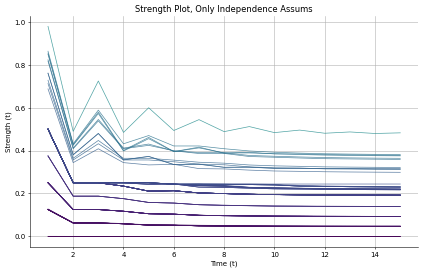

In [54]:
strengthplot(    graph_data={assum: series for assum, series in output.graph_data.items() if assum.startswith('indep')},
    title="Strength Plot, Only Independence Assums",
    xrange=15,
    wide=10,
    tall=6,
    cmap='viridis',
    dpi=50,
    linewidth_pt=1,
    alpha=0.8
).show()

In [28]:
# Most straightforward thing would be using all independence assumptions as is, ordered by these new strengths as independence facts
# dependence still stays lowest, so to not clutter let's only consider independence assumptions that didn't correspond to dependence facts 

In [29]:
dep_facts_tuples = set()
for fact in facts:
    if fact.relation == RelationEnum.dep:
        dep_facts_tuples.add((fact.node1, fact.node2, frozenset(fact.node_set)))

# create a new set of facts
def parse_indep_assum_name(assum_name, score):
    """
    Parse the assumption name to extract the nodes and set.
    Names of the form indep_0_1__2_3_4 or indep_0_1__2 or indep_0_1__
    The first two numbers separated by underscore are the nodes, and the rest is the set.
    """
    parts = [part for part in assum_name.split('_') if len(part) > 0]
    node1 = int(parts[1])
    node2 = int(parts[2])
    if len(parts) > 3:
        node_set = frozenset(int(x) for x in parts[3:] if x.isdigit())
    else:
        node_set = frozenset()
    return Fact(relation=RelationEnum.indep, node1=node1, node2=node2, node_set=node_set, score=score)

refined_facts = []
for assum_name, strength in output.indep_strengths.items():
    fact = parse_indep_assum_name(assum_name, strength)
    fact_id = (fact.node1, fact.node2, frozenset(fact.node_set))
    if fact_id not in dep_facts_tuples:
        refined_facts.append(fact)

In [30]:
refined_facts_location = get_fact_location(refined_facts, base_location='./refined_cancer_facts.lp')

In [ ]:
model_sets, multiple_solutions = CausalABA(
    n_nodes, refined_facts_location, weak_constraints=True, skeleton_rules_reduction=True,
    fact_pct=1.0, search_for_models='first',
    opt_mode='optN', print_models=False, set_indep_facts=False);

In [32]:
sorted(output.arrow_strengths.items(), key=lambda x: x[1], reverse=True)

[('arr_3_0', np.float64(0.5117519238323547)),
 ('arr_4_0', np.float64(0.5117519238323547)),
 ('arr_2_0', np.float64(0.5117432012641396)),
 ('arr_1_0', np.float64(0.5117432012641396)),
 ('arr_3_4', np.float64(0.5007463979094899)),
 ('arr_1_4', np.float64(0.5007461587603044)),
 ('arr_3_2', np.float64(0.5005931967021695)),
 ('arr_4_2', np.float64(0.5005931032677221)),
 ('arr_1_2', np.float64(0.5005904512862944)),
 ('arr_3_1', np.float64(0.4998043815605326)),
 ('arr_1_3', np.float64(0.49980139514903404)),
 ('arr_2_1', np.float64(0.4994082221668408)),
 ('arr_2_4', np.float64(0.49940689617612694)),
 ('arr_2_3', np.float64(0.4994067449959092)),
 ('arr_4_1', np.float64(0.49925378193116643)),
 ('arr_4_3', np.float64(0.49925355025140095)),
 ('arr_0_1', np.float64(0.48825679873586036)),
 ('arr_0_2', np.float64(0.48825679873586036)),
 ('arr_0_3', np.float64(0.48823935359943027)),
 ('arr_0_4', np.float64(0.48823935359943027)),
 ('noe_2_3', np.float64(0.4860954678432405)),
 ('noe_1_4', np.float64(0.

In [33]:
# noe always weaker than arrows which is not good.

In [34]:
reset_weights(assumptions_dict)

In [ ]:
default_output = run_model(
    n_nodes=n_nodes,
    bsaf=bsaf,
    model_name=None,
    set_aggregation=SetMinAggregation(),
    aggregation=TopDiffAggregation(),
    influence=LinearInfluence(conservativeness=1),
    conservativeness=1,
    iterations=50,
)

In [36]:
sorted(default_output.arrow_strengths.items(), key=lambda x: x[1], reverse=True)

[('arr_3_4', 0.5),
 ('arr_2_3', 0.5),
 ('arr_0_1', 0.5),
 ('arr_0_3', 0.5),
 ('arr_3_0', 0.5),
 ('arr_2_0', 0.5),
 ('arr_3_2', 0.5),
 ('arr_4_0', 0.5),
 ('arr_4_2', 0.5),
 ('arr_1_2', 0.5),
 ('arr_1_3', 0.5),
 ('arr_0_2', 0.5),
 ('arr_1_4', 0.5),
 ('arr_2_4', 0.5),
 ('arr_4_3', 0.5),
 ('arr_0_4', 0.5),
 ('arr_1_0', 0.5),
 ('arr_3_1', 0.5),
 ('arr_4_1', 0.5),
 ('arr_2_1', 0.5),
 ('noe_0_1', 0.3000000003938261),
 ('noe_1_4', 0.3000000003938261),
 ('noe_1_2', 0.3000000003938261),
 ('noe_0_4', 0.3000000003938261),
 ('noe_2_3', 0.3000000003938261),
 ('noe_2_4', 0.3000000003938261),
 ('noe_3_4', 0.3000000003938261),
 ('noe_1_3', 0.3000000003938261),
 ('noe_0_3', 0.3000000003938261),
 ('noe_0_2', 0.3000000003938261)]

In [37]:
default_arr_strengths = [s for name, s in default_output.arrow_strengths.items() if name.startswith('arr')]
assert max(default_arr_strengths) - min(default_arr_strengths) < 0.0001


default_noe_strengths = [s for name, s in default_output.arrow_strengths.items() if name.startswith('noe')]
assert max(default_noe_strengths) - min(default_noe_strengths) < 0.0001


In [38]:
arr_strengths = [s for name, s in output.arrow_strengths.items() if name.startswith('arr')]

noe_strengths = [s for name, s in output.arrow_strengths.items() if name.startswith('noe')]

In [39]:
scale = default_arr_strengths[0] - default_noe_strengths[0]

In [40]:
new_strengths = output.arrow_strengths

for name, value in new_strengths.items():
    if name.startswith('noe'):
        new_strengths[name] = value + scale

In [41]:
sorted(new_strengths.items(), key=lambda x: x[1], reverse=True) 

[('noe_2_3', np.float64(0.6860954674494144)),
 ('noe_1_4', np.float64(0.6195709630107091)),
 ('noe_3_4', np.float64(0.6157347144419529)),
 ('noe_2_4', np.float64(0.5799481183677171)),
 ('noe_1_3', np.float64(0.5761152942952449)),
 ('noe_1_2', np.float64(0.564581533763824)),
 ('arr_3_0', np.float64(0.5117519238323547)),
 ('arr_4_0', np.float64(0.5117519238323547)),
 ('arr_2_0', np.float64(0.5117432012641396)),
 ('arr_1_0', np.float64(0.5117432012641396)),
 ('arr_3_4', np.float64(0.5007463979094899)),
 ('arr_1_4', np.float64(0.5007461587603044)),
 ('arr_3_2', np.float64(0.5005931967021695)),
 ('arr_4_2', np.float64(0.5005931032677221)),
 ('arr_1_2', np.float64(0.5005904512862944)),
 ('arr_3_1', np.float64(0.4998043815605326)),
 ('arr_1_3', np.float64(0.49980139514903404)),
 ('arr_2_1', np.float64(0.4994082221668408)),
 ('arr_2_4', np.float64(0.49940689617612694)),
 ('arr_2_3', np.float64(0.4994067449959092)),
 ('arr_4_1', np.float64(0.49925378193116643)),
 ('arr_4_3', np.float64(0.499253

In [42]:
output.greedy_graph

array([[0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1],
       [1, 0, 0, 0, 0],
       [1, 1, 1, 0, 1],
       [1, 0, 1, 0, 0]])

In [43]:
output.arrow_strengths

{'noe_0_1': np.float64(0.4557998648492597),
 'arr_3_4': np.float64(0.5007463979094899),
 'arr_2_3': np.float64(0.4994067449959092),
 'arr_0_1': np.float64(0.48825679873586036),
 'noe_1_4': np.float64(0.6195709630107091),
 'arr_0_3': np.float64(0.48823935359943027),
 'arr_3_0': np.float64(0.5117519238323547),
 'noe_1_2': np.float64(0.564581533763824),
 'arr_2_0': np.float64(0.5117432012641396),
 'arr_3_2': np.float64(0.5005931967021695),
 'arr_4_0': np.float64(0.5117519238323547),
 'arr_4_2': np.float64(0.5005931032677221),
 'noe_0_4': np.float64(0.4557468404549676),
 'arr_1_2': np.float64(0.5005904512862944),
 'arr_1_3': np.float64(0.49980139514903404),
 'noe_2_3': np.float64(0.6860954674494144),
 'arr_0_2': np.float64(0.48825679873586036),
 'noe_2_4': np.float64(0.5799481183677171),
 'noe_3_4': np.float64(0.6157347144419529),
 'arr_1_4': np.float64(0.5007461587603044),
 'arr_2_4': np.float64(0.49940689617612694),
 'noe_1_3': np.float64(0.5761152942952449),
 'arr_4_3': np.float64(0.499

In [44]:
sorted(output.arrow_strengths.items(), key=lambda x: x[1], reverse=True) 

[('noe_2_3', np.float64(0.6860954674494144)),
 ('noe_1_4', np.float64(0.6195709630107091)),
 ('noe_3_4', np.float64(0.6157347144419529)),
 ('noe_2_4', np.float64(0.5799481183677171)),
 ('noe_1_3', np.float64(0.5761152942952449)),
 ('noe_1_2', np.float64(0.564581533763824)),
 ('arr_3_0', np.float64(0.5117519238323547)),
 ('arr_4_0', np.float64(0.5117519238323547)),
 ('arr_2_0', np.float64(0.5117432012641396)),
 ('arr_1_0', np.float64(0.5117432012641396)),
 ('arr_3_4', np.float64(0.5007463979094899)),
 ('arr_1_4', np.float64(0.5007461587603044)),
 ('arr_3_2', np.float64(0.5005931967021695)),
 ('arr_4_2', np.float64(0.5005931032677221)),
 ('arr_1_2', np.float64(0.5005904512862944)),
 ('arr_3_1', np.float64(0.4998043815605326)),
 ('arr_1_3', np.float64(0.49980139514903404)),
 ('arr_2_1', np.float64(0.4994082221668408)),
 ('arr_2_4', np.float64(0.49940689617612694)),
 ('arr_2_3', np.float64(0.4994067449959092)),
 ('arr_4_1', np.float64(0.49925378193116643)),
 ('arr_4_3', np.float64(0.499253

In [45]:
from ArgCausalDisco.utils.graph_utils import is_dag
from src.utils.utils import get_matrix_from_arrow_set, get_arrows_from_assumptions

In [46]:
def _get_nodes_from_arr_or_noe(asm_name: str) -> tuple:
    """
    Extracts the nodes from an assumption name that starts with 'arr_' or 'noe_'.
    
    :param asm_name: The assumption name to parse.
    :return: A tuple of integers representing the nodes in the assumption.
    """
    if not asm_name.startswith(('arr_', 'noe_')):
        raise ValueError(f"Assumption name {asm_name} must start with 'arr_' or 'noe_'.")

    try:
        _, node1, node2 = asm_name.split("_")
        node1 = int(node1)
        node2 = int(node2)
    except ValueError as e:
        raise ValueError(f"Arrow must be of form arr_<node1>_<node2>, got {asm_name}. Here is the exception {e}")

    return node1, node2

In [50]:
import src.causal_aba.assumptions as asm

sorted_arrow_strengths = sorted(
    output.arrow_strengths.items(),
    key=lambda item: item[1],
    reverse=True
)

accepted_assumptions = set()
for asm_name, _ in sorted_arrow_strengths:
    if len(accepted_assumptions) == n_nodes * (n_nodes - 1) // 2:
        # all possible edges are accepted, no need to check further
        break

    node1, node2 = _get_nodes_from_arr_or_noe(asm_name)

    # enforce mutual exclusivity of arr and noe assumptions
    if asm.arr(node1, node2) in accepted_assumptions or \
        asm.arr(node2, node1) in accepted_assumptions or \
        asm.noe(node1, node2) in accepted_assumptions:
        # is not accepted, moving on to next assumption
        continue

    # enforce acyclicity
    matrix = get_matrix_from_arrow_set(
        get_arrows_from_assumptions(
            accepted_assumptions),
        n_nodes)
    if not is_dag(matrix):
        # is not accepted, moving on to next assumption
        continue
    accepted_assumptions.add(asm_name)

greedy_matrix = get_matrix_from_arrow_set(
    get_arrows_from_assumptions(
        accepted_assumptions),
    n_nodes)

In [51]:
sorted_arrow_strengths

[('noe_2_3', np.float64(0.6860954674494144)),
 ('noe_1_4', np.float64(0.6195709630107091)),
 ('noe_3_4', np.float64(0.6157347144419529)),
 ('noe_2_4', np.float64(0.5799481183677171)),
 ('noe_1_3', np.float64(0.5761152942952449)),
 ('noe_1_2', np.float64(0.564581533763824)),
 ('arr_3_0', np.float64(0.5117519238323547)),
 ('arr_4_0', np.float64(0.5117519238323547)),
 ('arr_2_0', np.float64(0.5117432012641396)),
 ('arr_1_0', np.float64(0.5117432012641396)),
 ('arr_3_4', np.float64(0.5007463979094899)),
 ('arr_1_4', np.float64(0.5007461587603044)),
 ('arr_3_2', np.float64(0.5005931967021695)),
 ('arr_4_2', np.float64(0.5005931032677221)),
 ('arr_1_2', np.float64(0.5005904512862944)),
 ('arr_3_1', np.float64(0.4998043815605326)),
 ('arr_1_3', np.float64(0.49980139514903404)),
 ('arr_2_1', np.float64(0.4994082221668408)),
 ('arr_2_4', np.float64(0.49940689617612694)),
 ('arr_2_3', np.float64(0.4994067449959092)),
 ('arr_4_1', np.float64(0.49925378193116643)),
 ('arr_4_3', np.float64(0.499253

In [52]:
greedy_matrix

array([[0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0]])

In [53]:
B_true

array([[0, 1, 0, 0, 1],
       [0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]])

1. Experiment providing these indep fact strengths to rank models
    - Use original facts valuation
    - Use refined fact strengths.
    - Or use arrow and noe strengths.
2. Experiment providing these indep fact strengths to rank initial facts as well
    - Only consider independence facts tho

6 experiments to accomplish the above

------
3. Experiment with greedy graph construction. Construct greedily, beam search k steps in arrows, greedy regarding the independence fact strengths. try three valuations: original, corresponding to refined strengths, arrows.